In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
data_path = "/content/drive/MyDrive/data/"

In [3]:
import numpy as np
import pandas as pd
import librosa # to extract speech features
import glob
import os
import pickle # to save model after training
from sklearn.model_selection import train_test_split # for splitting training and testing
from sklearn.neural_network import MLPClassifier # multi-layer perceptron model
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report # to measure how good we are
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

In [4]:
data = pd.read_csv(data_path+'ANAD.csv')
print(data.head)

FileNotFoundError: ignored

In [ ]:
def extract_feature(file_name, mfcc, chroma, mel, contrast,tonnetz,spec_cent, zero_crossing_rate):
        X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        # if tonnetz:
        #     tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        #     result = np.hstack((result, tonnetz))
        if spec_cent:
            spec_cent = np.mean(librosa.feature.spectral_centroid(y=X, sr = sample_rate).T,axis=0)
            result = np.hstack((result, spec_cent))
        if zero_crossing_rate:
            zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=X).T, axis=0)
            result = np.hstack((result, zero_crossing_rate))
        return result

In [ ]:
def load_data(data_path):
  data=pd.read_csv(data_path+"ANAD.csv")
  data=data.iloc[:,[0,1]].copy()
  data["name"]=data["name"].apply(lambda x:x.replace("'",""))
  data["name"]=data_path+data["name"]
  full_data=data
  full_data.columns=["filePath","labels"]
  full_data.dropna(inplace=True)
  return full_data


def to_features(data_path):
  full_data=load_data(data_path)
  X = []
  files = glob.glob(data_path+"*.wav")
  for e in full_data["filePath"].values:
    if e in files:
      X.append(extract_feature(e, mfcc = True, chroma = True, mel = True, contrast = True,tonnetz = True,spec_cent = True, zero_crossing_rate = True))
    else:
      full_data.drop([full_data[full_data['filePath']==e].index.values[0]],inplace=True)
  X=np.array(X)
  print("features shape",X.shape)
  lb=LabelEncoder()
  labels=lb.fit_transform(full_data["labels"])
  # pca = PCA(n_components=round(X.shape[1]/10))
  # X = pca.fit(np.transpose(X))
  # print("Explained Variance: %s" % X.explained_variance_ratio_)
  # X = np.array(X.components_)
  # X = np.transpose(X)
  # print(X.shape)
  X_train, X_test, y_train, y_test=train_test_split(X, labels, test_size=0.15, random_state=45)
  return  X_train, X_test, y_train, y_test

def model_training(data_path):
  X_train, X_test, y_train, y_test=to_features(data_path)
  model_params = {
      'alpha': 0.0001,
      'batch_size': 64,
      'epsilon': 1e-08, 
      'hidden_layer_sizes': (512, 256, 128), 
      'learning_rate': 'adaptive', 
      'max_iter': 500}

  model = MLPClassifier(**model_params)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  print("Accuracy: {:.2f}%".format(accuracy*100))
  print(f1_score(y_test,y_pred,average=None))
  return model


In [ ]:
model=model_training(data_path)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1152
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1886
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1958
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1922
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1994
  n_fft, y.shape[-1]


features shape (1266, 189)
Accuracy: 79.47%
[0.85833333 0.70454545 0.65384615]


In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

X_train, X_test, y_train, y_test=to_features(data_path)
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

model = Sequential()


model.add(Conv1D(64, 5,padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(7))
model.add(Activation('softmax'))
opt = keras.optimizers.Adam(lr=0.0001)
model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
cnnhistory=model.fit(np.array(x_traincnn), np.array(y_train), batch_size=16, epochs=40, validation_data=(x_testcnn, y_test))

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1152
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1886
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1958
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1922
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1994
  n_fft, y.shape[-1]


features shape (1266, 189)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 189, 64)           384       
_________________________________________________________________
activation_16 (Activation)   (None, 189, 64)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 189, 64)           0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 47, 64)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 47, 128)           41088     
_________________________________________________________________
activation_17 (Activation)   (None, 47, 128)           0         
_________________________________________________________________
dropout_13 (Dropout)       

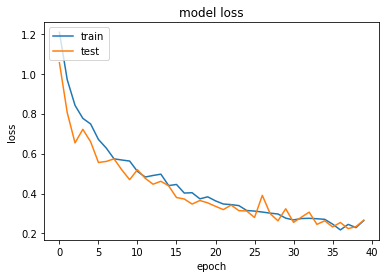

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

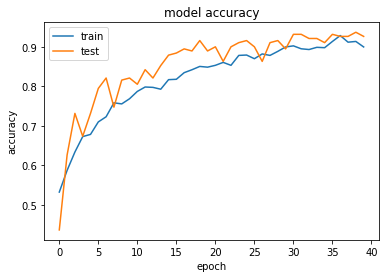

In [ ]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict_classes(x_testcnn)
new_Ytest = y_test.astype(int)
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       117
           1       0.84      0.98      0.91        54
           2       0.86      0.95      0.90        19

    accuracy                           0.93       190
   macro avg       0.90      0.94      0.92       190
weighted avg       0.93      0.93      0.93       190



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
